## 1: Connect to Snowflake raw and silver layers

In [110]:
#import libraries needed
from snowflake.snowpark.session import Session
import os

#Checking I am in correct environment
print (os.environ['CONDA_DEFAULT_ENV'])

#config to connect to Snowflake ELT Stage
snowflake_param_dict_elt = {
    'account': 'flb08246',   
    'user': 'HIPPO',              
    'password': 'Stoves99!!',    
    'role': 'ACCOUNTADMIN', 
    'warehouse': 'AH64595_WH',  
    'database': 'AH64595_DW',    
    'schema': 'ELT_STAGE'}

#initiate the session with config (I got an authentication I had to approve)
session_elt = Session.builder.configs(snowflake_param_dict_elt).create()

py38_env


In [111]:
#config to connect to Snowflake Silver Layer
snowflake_param_dict_silver = {
    'account': 'flb08246',   
    'user': 'HIPPO',              
    'password': 'Stoves99!!',    
    'role': 'ACCOUNTADMIN', 
    'warehouse': 'AH64595_WH',  
    'database': 'AH64595_DW',    
    'schema': 'EDW_SILVER_LAYER2'}

#initiate the session with config
session_silver = Session.builder.configs(snowflake_param_dict_silver).create()

## 2: Set up Snowflake Dataframes

In [112]:
#Create snowflake dataframes for the tables
sf_df_noc = session_elt.table('NOC_REGIONS_DW')
sf_df_athlete = session_elt.table('ATHLETE_EVENTS_DW')
sf_df_merged = session_silver.table('NOC_ATHLETE_EVENTS_MERGE')

In [113]:
#Show a couple of records to make sure it is pulling in correctly
sf_df_merged.show(3)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NOC"  |"COUNTRY"  |"ID"    |"NAME"                            |"SEX"  |"AGE"  |"HEIGHT"  |"WEIGHT"  |"GAMES"      |"YEAR"  |"YEAR_AS_DATE"  |"SEASON"  |"CITY"    |"CITY_YEAR"    |"SPORT"        |"SPORT_EVENT"                            |"MEDAL"  |"MEDAL_WON"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|GBR    |UK         |128952  |"Barrington J. ""Barry"" Watson"  |M      |32     |166.0     |51.0      |1976 Summer  |1976    |1976-01-01      |Summer    |Montreal  |Montreal 1976  |Athletics      |Athletics M

In [114]:
#Print out the size of each dataframe 
print(sf_df_noc.count())
print(sf_df_athlete.count())
print(sf_df_merged.count()) #deduped and cleaned, so should be less than raw

230
270443
268696


## 3: Run Analytics Models

In [6]:
!pip install statsmodels patsy

In [9]:
#Import packages for regression
import statsmodels.api as sm
from patsy import dmatrices

In [10]:
#pip install "snowflake-connector-python[pandas]"

In [115]:
#Set the merged dataframe to a pandas
p_df_merged = sf_df_merged.to_pandas()
p_df_merged.head()

,NOC,COUNTRY,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,GAMES,YEAR,YEAR_AS_DATE,SEASON,CITY,CITY_YEAR,SPORT,SPORT_EVENT,MEDAL,MEDAL_WON
0,GBR,UK,128952,"""Barrington J. """"Barry"""" Watson""",M,32.0,166.0,51.0,1976 Summer,1976,1976-01-01,Summer,Montreal,Montreal 1976,Athletics,Athletics Men's Marathon,None,0
1,AUS,Australia,58972,Michelle Kettner,F,27.0,162.0,68.0,2000 Summer,2000,2000-01-01,Summer,Sydney,Sydney 2000,Weightlifting,Weightlifting Women's Light-Heavyweight,None,0
2,URS,Russia,109161,Borys Anfiyanovych Shakhlin,M,32.0,171.0,71.0,1964 Summer,1964,1964-01-01,Summer,Tokyo,Tokyo 1964,Gymnastics,Gymnastics Men's Parallel Bars,None,0
3,DEN,Denmark,107079,Carl Richardt Schmidt,M,23.0,NaN,NaN,1928 Summer,1928,1928-01-01,Summer,Amsterdam,Amsterdam 1928,Rowing,Rowing Men's Coxed Eights,None,0
4,BUL,Bulgaria,59402,Khrabrina Bozhidarova Khrabrova,F,15.0,155.0,41.0,1988 Summer,1988,1988-01-01,Summer,Seoul,Seoul 1988,Gymnastics,Gymnastics Women's Balance Beam,None,0


In [11]:
p_df_merged.columns.values

array(['NOC', 'COUNTRY', 'ID', 'NAME', 'SEX', 'AGE', 'HEIGHT', 'WEIGHT',
       'GAMES', 'YEAR', 'YEAR_AS_DATE', 'SEASON', 'CITY', 'CITY_YEAR',
       'SPORT', 'SPORT_EVENT', 'MEDAL', 'MEDAL_WON'], dtype=object)

In [12]:
#select a subset of data for regression - because I will be using physical characteristics, I want to use the same sport
df_regress = p_df_merged[p_df_merged['SPORT'] == 'Swimming']
df_regress.head()

,NOC,COUNTRY,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,GAMES,YEAR,YEAR_AS_DATE,SEASON,CITY,CITY_YEAR,SPORT,SPORT_EVENT,MEDAL,MEDAL_WON
14,HUN,Hungary,60858,Lszl Kiss,M,19.0,170.0,67.0,1960 Summer,1960,1960-01-01,Summer,Roma,Roma 1960,Swimming,Swimming Men's 200 metres Butterfly,None,0
18,ESP,Spain,13816,Javier Botello Garca,M,21.0,180.0,70.0,2000 Summer,2000,2000-01-01,Summer,Sydney,Sydney 2000,Swimming,Swimming Men's 4 x 100 metres Medley Relay,None,0
23,USA,USA,131579,"""William Tripp """"Bill"""" Woolsey""",M,17.0,183.0,84.0,1952 Summer,1952,1952-01-01,Summer,Helsinki,Helsinki 1952,Swimming,"Swimming Men's 1,500 metres Freestyle",None,0
51,TPE,Taiwan,69961,Lin Chien-Ju,F,18.0,175.0,60.0,1996 Summer,1996,1996-01-01,Summer,Atlanta,Atlanta 1996,Swimming,Swimming Women's 4 x 100 metres Medley Relay,None,0
56,DEN,Denmark,86060,"Susanne Schultz Nielsson (-Feldsgaard, -Hansen)",F,16.0,165.0,60.0,1976 Summer,1976,1976-01-01,Summer,Montreal,Montreal 1976,Swimming,Swimming Women's 200 metres Breaststroke,None,0


In [13]:
#Set up matrices
y, X = dmatrices('MEDAL_WON ~ AGE + HEIGHT + WEIGHT', data=df_regress, return_type='dataframe')
X[:3]

,Intercept,AGE,HEIGHT,WEIGHT
14,1.0,19.0,170.0,67.0
18,1.0,21.0,180.0,70.0
23,1.0,17.0,183.0,84.0


In [14]:
#Run regression and fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.384968
         Iterations 6


In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              MEDAL_WON   No. Observations:                18627
Model:                          Logit   Df Residuals:                    18623
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Aug 2024   Pseudo R-squ.:                 0.01288
Time:                        10:03:24   Log-Likelihood:                -7170.8
converged:                       True   LL-Null:                       -7264.4
Covariance Type:            nonrobust   LLR p-value:                 2.484e-40
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.8209      0.580    -11.750      0.000      -7.959      -5.683
AGE            0.0054      0.006      0.867      0.386      -0.007       0.018
HEIGHT         0.0252      0.004      5.662      0.000       0.016       0.034
WEIGHT         0.0041      0.004      1.083      0.279      -0.003       0.012
==============================================================================
"""

Using logistic regression to determine how physical characteristics impact whether or not athletes win medals shows that there is very little statistically significant relationship between the variables. The Pseudo r-squared of 0.012 and the high p-values for age and weight demonstrate this. Height is the only variable that is shown to impact likelihood of winning a medal, which makes sense for swimming, but the coefficient is still rather small. 

In [50]:
#The next model will be seeing how height and weight will trend over time in the sport of athletics 
df_athletics = p_df_merged[p_df_merged['SPORT'] == 'Athletics']
df_athletics = df_athletics[df_athletics['SEX'] == 'M'] #just using men data for accuracy

In [48]:
#Now aggregating by year, I want to see the avg height and weight
annual_data = df_athletics.groupby('YEAR').agg({
    'HEIGHT': 'mean',
    'WEIGHT': 'mean'
}).reset_index()

annual_data[:5] #all data is in cm and kg

,YEAR,HEIGHT,WEIGHT
0,1896,174.875000,70.068966
1,1900,178.578947,74.526316
2,1904,178.229885,73.903614
3,1906,180.328947,74.744828
4,1908,178.132686,73.514286


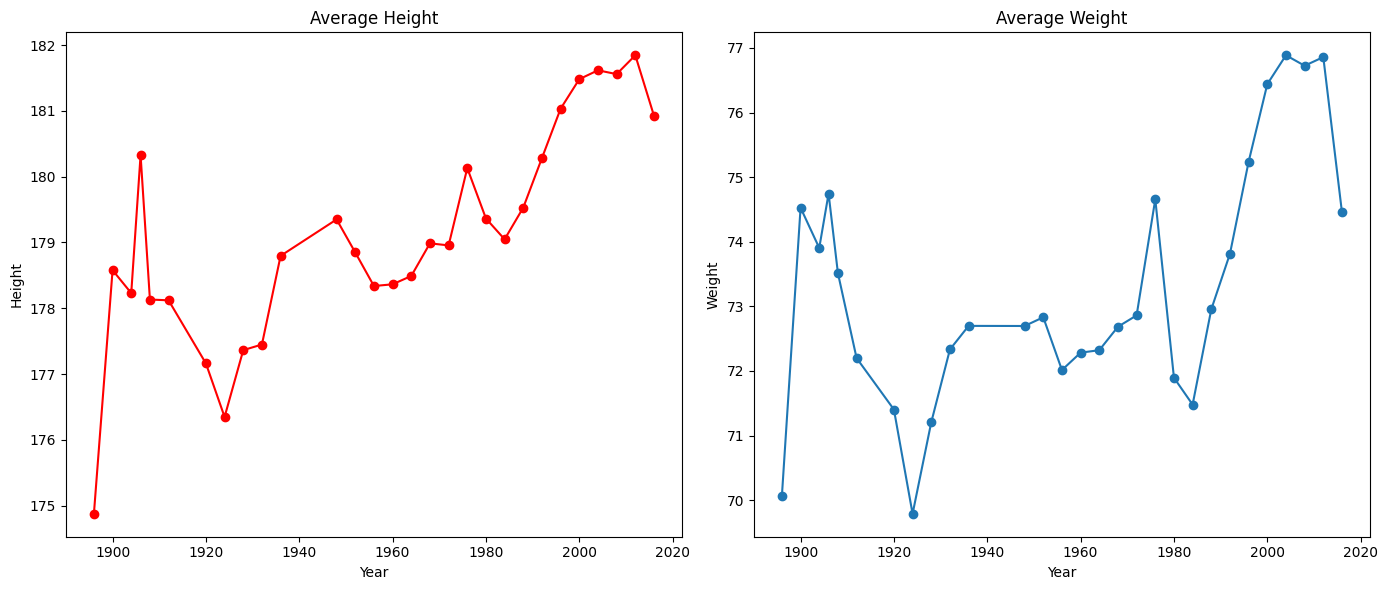

In [54]:
#Visualizing the data to see the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

#Creating subplots to compare side by side
#height plot
plt.subplot(1, 2, 1)
plt.plot(annual_data['YEAR'], annual_data['HEIGHT'], marker='o', color='red')
plt.title('Average Height')
plt.xlabel('Year')
plt.ylabel('Height')

#weight plot
plt.subplot(1, 2, 2)
plt.plot(annual_data['YEAR'], annual_data['WEIGHT'], marker='o')
plt.title('Average Weight')
plt.xlabel('Year')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

In [85]:
#Now using ARIMA I will predict a few years in the future
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model for height
height_model = ARIMA(annual_data['HEIGHT'], order=(1, 1, 1))
height_model_fit = height_model.fit()

# Forecasting the next 40 years
height_forecast = height_model_fit.forecast(steps=40)
print(height_forecast.head())

29    181.278808
30    180.968889
31    181.241607
32    181.001624
33    181.212801
Name: predicted_mean, dtype: float64


In [84]:
# Fit ARIMA model for weight
weight_model = ARIMA(annual_data['WEIGHT'], order=(1, 1, 1))
weight_model_fit = weight_model.fit()

# Forecasting the next 40 years
weight_forecast = weight_model_fit.forecast(steps=40)
print(weight_forecast.head())

29    74.628040
30    74.527196
31    74.585812
32    74.551741
33    74.571545
Name: predicted_mean, dtype: float64


/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/py38_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


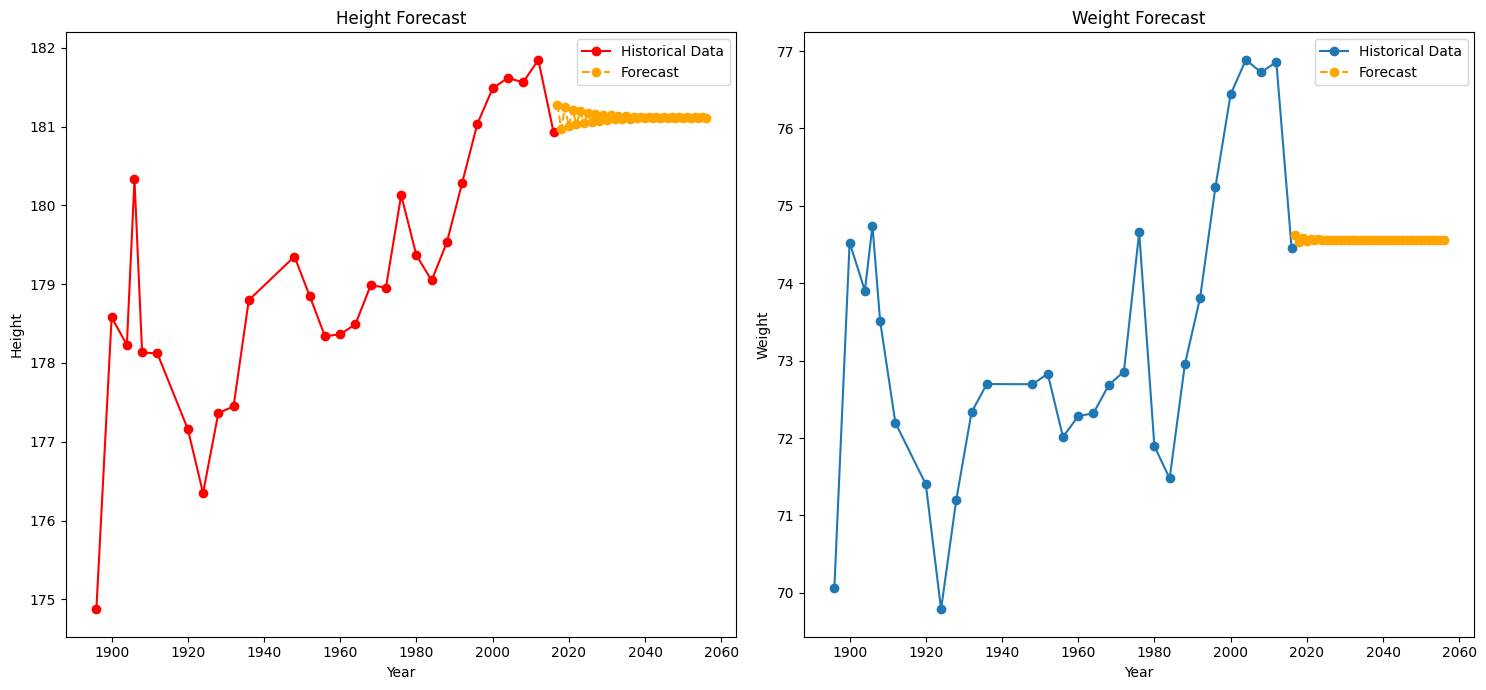

In [86]:
#Finally, visualize the forecasts on top of the existing data
future_years = list(range(annual_data['YEAR'].max() + 1, annual_data['YEAR'].max() + 41))


plt.figure(figsize=(15, 7))

#Height forecast
plt.subplot(1, 2, 1)
plt.plot(annual_data['YEAR'], annual_data['HEIGHT'], marker='o', label='Historical Data', color='red')
plt.plot(future_years, height_forecast, marker='o', linestyle='--', label='Forecast',color='orange')
plt.title('Height Forecast')
plt.xlabel('Year')
plt.ylabel('Height')
plt.legend()

#Weight Forecast
plt.subplot(1, 2, 2)
plt.plot(annual_data['YEAR'], annual_data['WEIGHT'], marker='o', label='Historical Data')
plt.plot(future_years, weight_forecast, marker='o', linestyle='--', label='Forecast', color='orange')
plt.title('Weight Forecast')
plt.xlabel('Year')
plt.ylabel('Weight')
plt.legend()

plt.tight_layout()
plt.show()

These charts show that either the data is not great for predicting future height and weight means, or based on trends, these measures will largely flatten out over the next 40 years or so. Either way, there are some limitations to using this data for future forecasts. 

## 4: Write the analytical outputs back to Snowflake

In [91]:
# I will first need to create a dataframe with the predicted heights and weights for the future
# Create a DataFrame with future years and predicted values

#same as above on the chart
future_years = list(range(annual_data['YEAR'].max() + 1, annual_data['YEAR'].max() + 41))

#create the 2 dfs to be merged with yearly predictions
height_forecast_df = pd.DataFrame({'YEAR': future_years, 'predicted_avg_height': height_forecast})
weight_forecast_df = pd.DataFrame({'YEAR': future_years, 'predicted_avg_weight': weight_forecast})
height_forecast_df[-1:]

,YEAR,predicted_avg_height
68,2056,181.112829


In [94]:
#Now merge the height and weight forecasts into one
athletics_forecast_df = pd.merge(height_forecast_df, weight_forecast_df, on='YEAR')
athletics_forecast_df.head()

,YEAR,predicted_avg_height,predicted_avg_weight
0,2017,181.278808,74.628040
1,2018,180.968889,74.527196
2,2019,181.241607,74.585812
3,2020,181.001624,74.551741
4,2021,181.212801,74.571545


In [116]:
#Connect to the gold layer in Snowflake
snowflake_param_dict_gold = {
    'account': 'flb08246',   
    'user': 'HIPPO',              
    'password': 'Stoves99!!',    
    'role': 'ACCOUNTADMIN', 
    'warehouse': 'AH64595_WH',  
    'database': 'AH64595_DW',    
    'schema': 'EDW_GOLD_LAYER2'}

#initiate the session with config
session_gold = Session.builder.configs(snowflake_param_dict_gold).create()

In [117]:
#Create a snowflake data frame for the pandas df
sf_athletics_forecast = session_gold.create_dataframe(athletics_forecast_df)

In [118]:
#Write the results to the gold layer
sf_athletics_forecast.write.mode('overwrite').save_as_table("ATHLETICS_FORECAST")